<a href="https://colab.research.google.com/github/kimurash/voice_actor_recognition/blob/main/voice_actor_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 声優100人の話者認識

## 実験の動機

長年アニメを見続けていると，よく起用されている声優さんを識別できるようになってくる．
これは声優さんの声の特徴を脳が非意図的に学習するためだ考えられるが，同じことを機械学習でも実現できるはずだと思ったのがこの実験の動機である．

## 学習データの用意

学習データとして，東京大学の[高道 慎之介 助教](https://sites.google.com/site/shinnosuketakamichi/home)がCC BY-SA ライセンスに基づいて公開している [JVS corpus](https://sites.google.com/site/shinnosuketakamichi/research-topics/jvs_corpus) という音声コーパスのうち，[日本声優統計学会](https://voice-statistics.github.io/)が独自に構築した音素バランス文を，100人のプロフェッショナル話者 (声優・俳優など) が読み上げた音声が収録された `parallel100` を採用する．

Colaboratory に Google Drive をマウントすることで保管してある音声データを読み込めるようにする．

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# 本実験に用いるデータが保管されたディレクトリへのパス
base_path = './drive/MyDrive/Colab Notebooks/personal/voice_actor_recog/'

Mounted at /content/drive


## 特徴量の抽出

今回の実験ではMFCC: Mel Frequrency Cepstrum Coefficientと呼ばれる特徴量を採用した．以降では，MFCCがどういう特徴量であるか説明することで**音声認識**における有効性を示し，手順に沿って実際に計算することでMFCCの理解に努める．

### **音声認識**に有効な特徴量

**音声認識**を行う場合は，音素を区別するための情報が必要である．人間の発声メカニズムを解き明かすことで，音素の違いは共振周波数の違いとなって現れることが分かる．そこで，音声信号をフーリエ変換によってスペクトルに変換し，スペクトルの山 (フォルマント) を観測することで共振周波数の情報を得るという方法が考えられる．しかし，スペクトルには共振周波数の情報 (スペクトルの概形) だけでなく，基本周波数の情報 (微細な振動) も乗っているため，この情報をうまく取り除く必要がある．このため，スペクトルをさらにフーリエ変換して低周波成分と高周波成分に分離し，低周波成分のみを使用するというのがMFCCの基本的なアイデアである．

ここまでの説明を踏まえて，1フレームの音声信号からMFCCを求める手順を以下に示す．フレームとは，音声信号から一部分を切り出すときの単位であり，フレーム長は通常25ms程度に設定する[1]．

1. フレーム両端での急激な変化を避けるために窓関数をかける．
2. フレームの音声波形をフーリエ変換する．  
3. 人間の聴覚特性を反映させるためにメルフィルタバンクをかける．
3. 3.で得られたスペクトルをさらに離散コサイン変換し，低周波成分と高周波成分に分ける．
5. 離散コサイン変換の低次の係数から12次元を取り出す．

**音声認識**では，フレームを10ms程度ずらしながら上記の処理を行う．これは人間の聴覚の時間分解能に対応している[1]．

### 実験の方針

ここまで長々とMFCCについて説明してきたが，本実験のタスクは**音声認識**ではなく**話者認識**であることを思い出して欲しい．同じ内容を読み上げた音声ファイルから話者を識別するには，「何を話しているか」よりも「どのように話しているか」の方が重要である．スペクトルに乗っている基本周波数の情報は声の高さ(イントネーション)を表しており，この情報は離散フーリエ変換後の高周波成分に現れる．したがって，本実験タスクにおいては，MFCCの低次元よりも高次元の情報を用いた方がうまく識別できると考えられる．

本実験では，MFCCの低次から12次元とった場合と，高次から12次元とった場合で識別性能を比較してみようと思う．

### MFCCを計算してみる

本節では [JVS corpus](https://sites.google.com/site/shinnosuketakamichi/research-topics/jvs_corpus) に用意されているサンプルファイル `sample_jvs001.wav` を用いて実際にMFCCを計算してみる．

必要なライブラリを読み込む．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(suppress=True, precision=7)

import os
import soundfile as sf

#### 1フレームを切り出す

sampling rate:24000


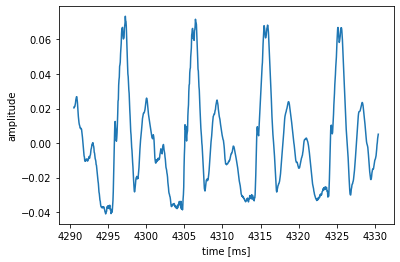

In [24]:
data, fs = sf.read(base_path + 'sample_jvs001.wav')
print(f'sampling rate:{fs}')

time = np.arange(0, len(data)/fs, 1/fs)

center = len(data) // 2
cuttime = 0.04
x = data[int(center - (cuttime / 2) * fs) : int(center + (cuttime/2) * fs)]
t = time[int(center - (cuttime / 2) * fs) : int(center + (cuttime/2) * fs)]

plt.plot(t * 1000, x)
plt.xlabel("time [ms]")
plt.ylabel("amplitude")
plt.show()

#### 窓関数をかけてフーリエ変換する

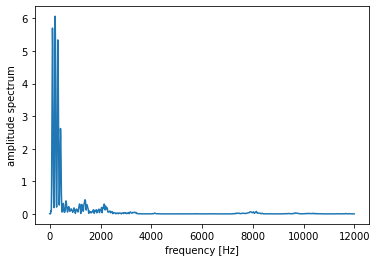

In [25]:
# ハミング窓をかける
hamming = np.hamming(len(x))
x = x * hamming

N = 2048 # FFTのサンプル数(2の累乗で高速化)

# ナイキスト周波数以下のデータを取り出す
spectre = np.abs(np.fft.fft(x, N))[:N // 2] # フーリエ変換
fscale = np.fft.fftfreq(N, d = 1.0 / fs)[:N // 2] # フーリエ変換の周波数を取得

plt.plot(fscale, spectre)
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude spectrum")
plt.show()

#### メルフィルタバンクをかける

メルフィルタバンクを求める手順を以下に示す．

1. ナイキスト周波数をメル尺度に変換する．
2. メル尺度上で0からナイキスト周波数までの区間をチャンネル数で等分割する．
3. 2.で求めた分割を周波数に変換する．
4. 分割の各点を底辺の中点とする三角フィルタを作成する．

周波数とメル尺度を変換する関数をあらかじめ定義しておく．

In [26]:
def hz2mel(f):
    """Hzをmelに変換"""
    return 2595 * np.log(f / 700.0 + 1.0)

def mel2hz(m):
    """melをHzに変換"""
    return 700 * (np.exp(m / 2595) - 1.0)

メルフィルタバンクを作成する関数を定義する．

関数内で使われている変数をアルゴリズムと共に図示した画像を用意した．  
関数の定義と照らし合わせながら読むことで，理解の一助となれば嬉しい．

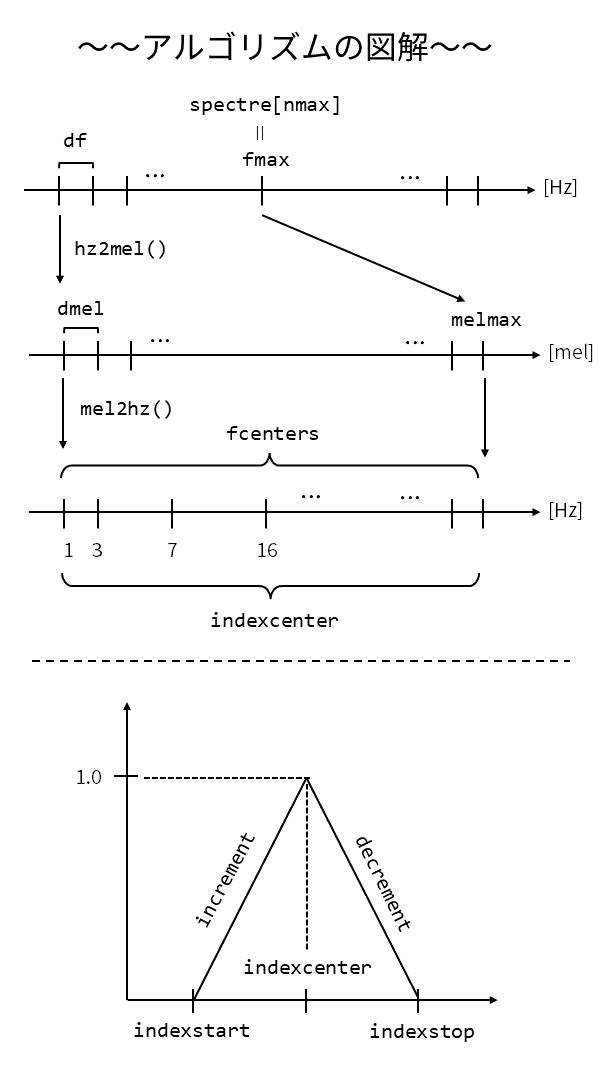

In [27]:
from IPython.display import Image,display_png

img_path = base_path + '/mel_filter_bank.png'
display_png(Image(data=img_path, width=550, height=1000))

In [28]:
def mel_filter_bank(fs, N, n_channel):
    """メルフィルタバンクを作成"""
    # ナイキスト周波数[Hz]
    fmax = fs / 2
    # ナイキスト周波数[mel]
    melmax = hz2mel(fmax)
    # 周波数インデックスの最大値
    nmax = N // 2
    # 周波数解像度(周波数インデックス1あたりの[Hz]幅)
    df = fs / N

    # メル尺度における各フィルタの中心周波数を求める
    dmel = melmax / (n_channel + 1)
    melcenters = np.arange(1, n_channel + 1) * dmel

    # 各フィルタの中心周波数を[Hz]に変換
    fcenters = mel2hz(melcenters)
    # 各フィルタの中心周波数を周波数インデックスに変換
    indexcenter = np.round(fcenters / df)

    # 各フィルタの開始位置のインデックス
    indexstart = np.hstack(([0], indexcenter[0:n_channel - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:n_channel], [nmax]))

    filterbank = np.zeros((n_channel, nmax))
    # print(indexstop)

    for c in range(0, n_channel): # c: channel
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c]) # 右上がりの傾き

        for i in range(int(indexstart[c]), int(indexcenter[c])):
            filterbank[c, i] = (i - indexstart[c]) * increment

        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c]) # 右下がりの傾き
        for i in range(int(indexcenter[c]), int(indexstop[c])):
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

上で定義した関数を用いてメルフィルタバンクを作成し，描画する．

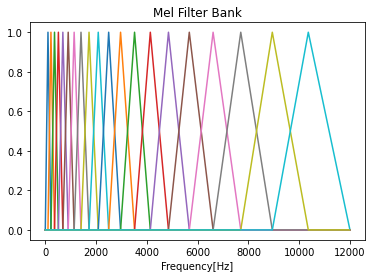

In [29]:
n_channel = 20 # メルフィルタバンクのチャネル数
df = fs / N    # 周波数解像度(周波数インデックス1あたりの[Hz]幅)
filterbank, fcenters = mel_filter_bank(fs, N, n_channel)

# メルフィルタバンクのプロット
for c in np.arange(0, n_channel):
    plt.plot(np.arange(0, N // 2) * df, filterbank[c])

plt.title('Mel Filter Bank')
plt.xlabel('Frequency[Hz]')
plt.show()

In [30]:
# 振幅スペクトルにメルフィルタバンクを適用
mspectre = np.dot(spectre, filterbank.T)

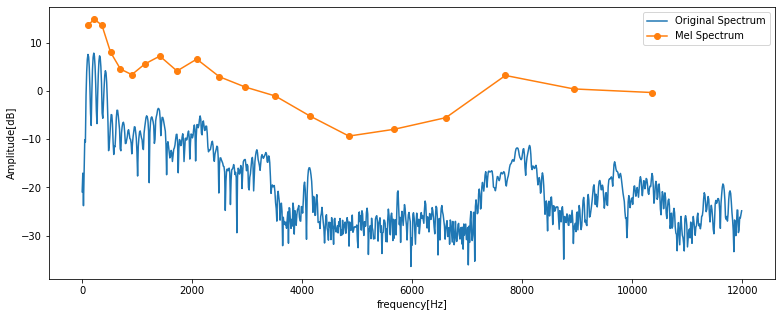

In [31]:
# 元の振幅スペクトルとフィルタバンクをかけて圧縮したスペクトルを表示
plt.figure(figsize=(13, 5))

plt.plot(fscale, 10 * np.log10(spectre), label='Original Spectrum')
plt.plot(fcenters, 10 * np.log10(mspectre), "o-", label='Mel Spectrum')
plt.xlabel("frequency[Hz]")
plt.ylabel('Amplitude[dB]')
plt.legend()
plt.show()

#### 離散コサイン変換する

In [32]:
from scipy.fftpack.realtransforms import dct

cepstre = dct(10 * np.log10(mspectre), type=2, norm="ortho", axis=-1)
print(cepstre.shape)
print(cepstre)

(20,)
[13.3190939 24.2771886  6.9022144 -3.5544651 12.9122567  0.5574299
 -1.8089861  1.496971  -6.083573   0.5448475 -2.8065642 -0.0265315
  0.8130684  0.1490588 -0.9149896 -1.70858    2.6811971 -0.3079438
  1.3090417 -1.841087 ]


### Librosaを用いたMFCCの算出

前節では音声データの1フレームに対してMFCCを求めたが，[Librosa](https://librosa.org/doc/latest/index.html) というライブラリを利用すると，各フレームのMFCCを簡単に計算できる．以下のセルでは，全音声データに対して，各フレームのMFCCを Librosa の `librosa.feature.mfcc` 関数を利用して計算し，時間平均をとった結果をCSVファイルとして保存する．

In [5]:
import librosa

X_data = []  # 特徴行列
y_data = []  # 正解情報

for speaker in range(1, 101):
    # print(f'No.{speaker_num}') # 進捗確認

    # 音声データが入っているディレクトリ名
    dir_name = base_path + f'jvs_ver1/jvs{str(speaker).zfill(3)}/parallel100/wav24kHz16bit'
    for file_name in os.listdir(dir_name):
         # 音声ファイルへのパス
        file_path = os.path.join(dir_name, file_name)
        # 音声ファイルを読み込む
        y, sr = librosa.load(file_path)

        mfcc = librosa.feature.mfcc(y, sr) # MFCCを算出
        mfcc = np.average(mfcc, axis=1) # 時間平均を取る
        mfcc = mfcc.flatten()
        mfcc = mfcc.tolist()
        X_data.append(mfcc)
        y_data.append(speaker)

X = pd.DataFrame(X_data, columns=[f'mfcc_{n}' for n in range(0, 20)])
y = pd.DataFrame({'target': y_data})

df = pd.concat([X, y], axis=1)
df.to_csv('mfcc.csv', index=False) # CSVで保存

print(df.shape)
df.head()

(9997, 21)


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,target
0,-406.077911,69.616173,5.507440,14.743916,4.551410,-9.362970,-6.035157,15.677253,-16.771376,-2.346049,...,-12.573087,-3.524272,-5.719043,-18.324978,-2.818250,-5.371923,-3.069093,-7.313135,-2.188849,1
1,-434.147552,77.291031,6.699678,14.172637,5.598119,-7.924884,-4.682566,15.697062,-14.664041,-3.669486,...,-9.980092,-4.588111,-3.999643,-16.731550,-2.347479,-4.715246,1.224066,-6.574102,-2.369225,1
2,-407.764404,82.102570,3.619558,8.675559,1.685305,-8.716214,-3.717378,13.641570,-14.984233,-3.654552,...,-10.859071,-3.957657,-5.204740,-18.052351,-5.586807,-4.321259,-1.929936,-7.707550,-2.960203,1
3,-446.516846,59.234222,8.543715,18.219103,7.780375,-3.081481,-4.141963,13.044106,-10.602309,-0.732245,...,-7.666026,-1.879559,-1.844411,-16.628784,-2.397813,-3.187749,0.473709,-8.178372,-2.779823,1
4,-388.319855,82.455490,3.929563,12.031418,0.774454,-11.123068,-6.059217,15.605132,-19.640221,0.520216,...,-12.775943,-3.546141,-4.827557,-18.637909,-2.985661,-7.504961,0.763457,-8.740715,-3.849721,1


全データ数は $100 \times 100 = 10^4$ だと思っていたが， $9997$ となっている．  
元データを確認すると，いくつか音声データが欠けていることが判明した．

## 学習と評価

大学の講義では主に scikit-learn と TensorFlow を扱ったが，ここでは文献[2]を参考にして [PyCaret](https://pycaret.gitbook.io/docs/) というライブラリを使ってみようと思う．

In [ ]:
!pip install pycaret

In [6]:
from pycaret.classification import *

保存したCSVファイルからMFCCを読み込む．

In [11]:
data = pd.read_csv('./mfcc.csv') # 保存したCSVファイルへのパス

# data = data.iloc[:, [*list(range(12)), 20]] # 低次元
data = data.iloc[:, 8:] # 高次元

data['target'] = data['target'] - 1 # クラスラベルを1ずらす
data.head()

,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,target
0,-16.771376,-2.346047,-12.703731,-12.573085,-3.524272,-5.719041,-18.324978,-2.818249,-5.371924,-3.069092,-7.313135,-2.188848,0
1,-14.664041,-3.669484,-11.074874,-9.980092,-4.588109,-3.999642,-16.731550,-2.347478,-4.715246,1.224067,-6.574103,-2.369224,0
2,-14.984233,-3.654551,-11.442192,-10.859071,-3.957658,-5.204739,-18.052351,-5.586806,-4.321259,-1.929936,-7.707550,-2.960202,0
3,-10.602308,-0.732244,-11.285127,-7.666025,-1.879558,-1.844411,-16.628784,-2.397813,-3.187750,0.473709,-8.178372,-2.779822,0
4,-19.640219,0.520218,-9.907987,-12.775942,-3.546140,-4.827555,-18.637911,-2.985659,-7.504962,0.763458,-8.740716,-3.849721,0


学習の設定を行う．

In [ ]:
setup(
    data=data, target='target',
    train_size=0.7,
    normalize=True,
    normalize_method='zscore', # スケーリング手法
    data_split_shuffle=True,   # データ分割に際してデータをシャッフルする
    fold=5,    # 交差確認法の分割数
    n_jobs=-1, # 全プロセッサを使用して並列実行
    use_gpu=True, silent=True)

利用できるモデルの一覧を表示する．

In [9]:
models()

INFO:logs:gpu_param set to True


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


極端に学習が遅いモデルは除外して性能を比較する．

In [13]:
best = compare_models(exclude=['gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9767,0.9999,0.9767,0.9789,0.9767,0.9765,0.9765,0.250
knn,K Neighbors Classifier,0.9608,0.9960,0.9601,0.9634,0.9603,0.9604,0.9605,1.172
et,Extra Trees Classifier,0.9568,0.9995,0.9561,0.9594,0.9564,0.9564,0.9564,6.866
lr,Logistic Regression,0.9457,0.9996,0.9453,0.9484,0.9453,0.9451,0.9452,2.366
rf,Random Forest Classifier,0.9413,0.9993,0.9410,0.9440,0.9407,0.9407,0.9407,9.424
lda,Linear Discriminant Analysis,0.9345,0.9995,0.9344,0.9388,0.9342,0.9339,0.9339,0.564
nb,Naive Bayes,0.9138,0.9990,0.9133,0.9199,0.9142,0.9129,0.9130,0.236
lightgbm,Light Gradient Boosting Machine,0.8872,0.9967,0.8861,0.8932,0.8870,0.8861,0.8862,29.918
svm,SVM - Linear Kernel,0.7485,0.0000,0.7473,0.9058,0.7956,0.7459,0.7506,0.764
dt,Decision Tree Classifier,0.6872,0.8420,0.6862,0.7032,0.6876,0.6840,0.6841,0.580


INFO:logs:create_model_container: 13
INFO:logs:master_model_container: 13
INFO:logs:display_container: 2
INFO:logs:QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)
INFO:logs:compare_models() succesfully completed......................................


`gbc` 以外の全てのモデルが評価対象に含まれてないのは何故だろう．

直前のコードセルの出力は，各モデルのデフォルトのパラメータを用いて学習させた結果である．PyCaret ではここからパラメータの調整もできるようになっている．恐るべし．

In [14]:
tuned = tune_model(best)
predict_model(tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9679,0.9999,0.9670,0.9704,0.9677,0.9675,0.9676
1,0.9643,0.9999,0.9636,0.9668,0.9641,0.9639,0.9640
2,0.9678,0.9999,0.9675,0.9699,0.9675,0.9675,0.9675
3,0.9600,0.9998,0.9595,0.9624,0.9593,0.9596,0.9596
4,0.9650,0.9999,0.9648,0.9672,0.9647,0.9646,0.9646
Mean,0.9650,0.9999,0.9645,0.9673,0.9647,0.9646,0.9647
Std,0.0029,0.0000,0.0029,0.0029,0.0031,0.0029,0.0029


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 3
INFO:logs:QuadraticDiscriminantAnalysis(priors=None, reg_param=0.26,
                              store_covariance=False, tol=0.0001)
INFO:logs:tune_model() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.26,
                              store_covariance=False, tol=0.0001), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.9633,0.9995,0.966,0.9663,0.963,0.963,0.963


,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,target,Label,Score
0,-1.791273,-0.813080,0.540968,-0.172749,-0.941744,1.706620,-1.363003,0.390721,-0.146744,0.698333,2.506359,2.233332,13,13,1.0000
1,-1.424081,-0.161605,-1.502280,1.246076,-0.946695,-1.071474,0.907517,-1.852941,-0.422839,0.937872,-3.528243,1.062655,76,76,1.0000
2,-0.603853,0.409088,-1.275670,1.415898,-0.322849,1.390981,-0.669469,0.030509,0.064247,-0.928644,0.408001,-1.100312,64,64,0.9803
3,1.125904,0.290464,-0.961848,1.078983,-1.295378,-0.017969,-0.462431,-0.225192,0.644663,-0.137468,-0.756707,1.048512,15,15,0.7758
4,0.844751,1.179189,0.367359,0.954606,-0.345100,-1.323318,1.835905,0.160658,-0.639797,0.666306,0.247593,-0.393702,99,99,0.9525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.366480,1.215562,-1.550293,-0.433060,-1.497672,2.020582,-0.206214,0.518060,-0.120394,-0.238255,-1.335594,-0.191704,62,62,0.9979
2996,0.186567,-0.324863,1.622369,-1.187052,-0.289645,-1.102727,1.032621,-0.482762,-1.404019,1.637034,-0.103544,-0.631369,74,74,0.9991
2997,1.476891,-0.932415,1.165538,-0.557417,0.929140,-0.348897,0.053719,0.860161,-0.539392,-0.667244,0.941765,0.069399,89,89,0.9343
2998,-1.182471,-0.355979,-0.295684,-1.605903,0.384712,-1.051158,-3.144795,-0.082152,-0.338130,-0.014212,-0.228734,-0.423104,0,0,1.0000


## 結果と考察

MFCCの低次から12次元取り出した特徴量と，高次から12次元取り出した特徴量を用いた場合の正解率を以下の表にまとめる．

| モデル   | 低次元 | 高次元 | 
| -------: | :----: | :----: | 
| qda      | 0.9831 | 0.9767 | 
| lda      | 0.9754 | 0.9345 | 
| lr       | 0.9723 | 0.9457 | 
| et       | 0.9653 | 0.9508 | 
| knn      | 0.9644 | 0.9608 | 
| rf       | 0.9500 | 0.9413 | 
| nb       | 0.9487 | 0.9138 | 
| lightgbm | 0.9050 | 0.8872 | 
| svm      | 0.8139 | 0.7485 | 
| dt       | 0.7290 | 0.6872 | 
| ridge    | 0.6867 | 0.6576 | 
| ada      | 0.0762 | 0.0616 | 
| dummy    | 0.0110 | 0.0114 | 


予想に反して，高次元よりも低次元の情報を使った方が全体的に正解率は高かった．これは，MFCCの低次元の情報にも話者認識に有効な特徴が含まれていることを意味する．

音声は，肺から押し出された空気が声帯の制御によってパルス波になり，それが口と鼻から成る声道で共振して生み出される．音素の違いは，口の開き具合や舌の位置といった声道の変形によって生じるため，音声認識にはMFCCの低次元の情報が有効であることは先に述べた通りである．低次元の情報を用いても正確に話者を識別できたことから，声道の形状には個人差があり，それが共振周波数の違いとなって現れた可能性が考えられる．

## 参考文献

1. 荒木雅弘：”フリーソフトでつくる音声認識システム”，森北出版株式会社，2018．
2. [声優100人をキレイに話者識別するための機械学習レシピ - Qiita](https://qiita.com/adumaru0828/items/a95de3a0fbfe54f51953)
3. [librosa - librosa latest documentation](https://librosa.org/doc/latest/index.html)
3. [Welcome to PyCaret - PyCaret Official](https://pycaret.gitbook.io/docs/)
4. [声の特性を決めるもの - 国際電気通信基礎技術研究所](https://results.atr.jp/atrj/ATRJ_36/06/main.html)